In [2]:
!pip install neurokit2
!pip install xgboost

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=df3b0f5fcd30d741781d4f35d70d9f661f758ef6e7680e609fd1473125f37161
  Stored in directory: C:\Users\Lea\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [8]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import neurokit2 as nk
from pprint import pprint

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

# Custom
import sys,os
sys.path.append( '.' )
sys.path.append( '..' )
import Components.data_fetching as data_fetching
import Components.feature_extraction as feature_extraction

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(data_fetching)
importlib.reload(feature_extraction)

<module 'Components.feature_extraction' from '..\\Components\\feature_extraction.py'>

# Data Fetching

In [14]:
y = data_fetching.get_train_data(y_only=True)


In [15]:
X = feature_extraction.get_features(types=['timeseries', 'heartbeats', 'peaks'], verbose=True, precomputed='train')
X_test = feature_extraction.get_features(types=['timeseries', 'heartbeats', 'peaks'], verbose=True, precomputed='test')

scaling

In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test_sc = scaler.transform(X_test)

# Feature selection

In [44]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False,max_iter=5000).fit(X, y)
model1 = SelectFromModel(lsvc, prefit=True)
X_new = model1.transform(X)
X_new.shape

(5117, 131)

In [30]:
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False,max_iter=5000).fit(X, y)
model2 = SelectFromModel(lsvc, prefit=True)
X_new2 = model2.transform(X)
X_new2.shape

(5117, 290)

In [38]:
lsvc = LinearSVC(C=1, penalty="l1", dual=False,max_iter=5000).fit(X, y)
model3 = SelectFromModel(lsvc, prefit=True)
X_new3 = model3.transform(X)
X_new3.shape

(5117, 417)

# Outlier detection

with C=0.01

In [42]:
detector = IsolationForest(contamination=170/5117,random_state=42)
labels = pd.DataFrame(detector.fit_predict(X_new))
labels.where(labels ==  -1).count()

C:\Users\Lea\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    170
dtype: int64

In [45]:
detector = IsolationForest(random_state=42)
labels = pd.DataFrame(detector.fit_predict(X_new))
labels.where(labels ==  -1).count()

C:\Users\Lea\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    512
dtype: int64

with C=0.1

In [32]:
detector = IsolationForest()
labels2 = pd.DataFrame(detector.fit_predict(X_new2))
labels2.where(labels2 ==  -1).count()

C:\Users\Lea\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    512
dtype: int64

with C=1

In [46]:
detector = IsolationForest()
labels3 = pd.DataFrame(detector.fit_predict(X_new3))
labels3.where(labels3 ==  -1).count()

C:\Users\Lea\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    512
dtype: int64

without any feature selection before

In [47]:
detector = IsolationForest()
labels4 = pd.DataFrame(detector.fit_predict(X))
labels4.where(labels4 ==  -1).count()

C:\Users\Lea\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    512
dtype: int64

remove found outliers

In [57]:
X1 = pd.DataFrame(X_new)[labels[0]==1]
X1_all = pd.DataFrame(X)[labels[0]==1]
y1 = pd.DataFrame(y)[labels[0]==1]

In [19]:
X2 = pd.DataFrame(X_new2)[labels2[0]==1]
X2_all = pd.DataFrame(X)[labels2[0]==1]
y2 = pd.DataFrame(y)[labels2[0]==1]

In [59]:
X3 = pd.DataFrame(X_new3)[labels3[0]==1]
X3_all = pd.DataFrame(X)[labels3[0]==1]
y3 = pd.DataFrame(y)[labels3[0]==1]

# Training

In [64]:


clf = xgb.XGBClassifier()
cv_score = cross_val_score(clf, X3_all, np.ravel(y3), cv=10, scoring='f1_micro')
print(cv_score)
print(np.mean(cv_score))

# 1st attempt
# [0.62304688 0.71875    0.76953125 0.74414062 0.73046875 0.72265625
# 0.7109375  0.7260274  0.72994129 0.66144814]
# 0.7136948079745596

# 2nd attempt
# [0.73242188 0.74023438 0.83007812 0.7578125  0.75976562 0.74804688
# 0.76171875 0.74168297 0.73972603 0.75342466]
# 0.7564911784491194

# 3rd attempt (luke's features)
# [0.72070312 0.76171875 0.82421875 0.76757812 0.78515625 0.75585938
# 0.76171875 0.76125245 0.7592955  0.77299413]
# 0.7670495199363991

# 4th attempt (luke's + lea's features)
# [0.80859375 0.79492188 0.83984375 0.81640625 0.80273438 0.80664062
# 0.81054688 0.78669276 0.7964775  0.82387476]
# 0.8086732509784735

# 147 outliers, 132 features
#[0.81287726 0.80482897 0.83098592 0.81287726 0.80080483 0.80885312
# 0.80684105 0.80885312 0.80885312 0.82293763]
# 0.811871227364185

# 147 outliers, all features
# [0.81086519 0.80885312 0.82092555 0.81891348 0.82092555 0.81891348
# 0.80885312 0.80482897 0.81891348 0.81488934]
# 0.8146881287726357

# 175 outliers, 282 features
#[0.82626263 0.80606061 0.85222672 0.82995951 0.82186235 0.81174089
# 0.81578947 0.7854251  0.8097166  0.82793522]
# 0.8186979102768575

#175 outliers, all features
#[0.82222222 0.81414141 0.84008097 0.81578947 0.82591093 0.80769231
# 0.80566802 0.78744939 0.80769231 0.82591093]
#0.8152557968347441


# 186 outliers, 407 features
#[0.82388664 0.80324544 0.84381339 0.81947262 0.82758621 0.79918864
# 0.82758621 0.78904665 0.80730223 0.82150101]
#0.8162629033185242

# 186 outliers, all features
#[0.83805668 0.80730223 0.83772819 0.80933063 0.82352941 0.81135903
# 0.81744422 0.78498986 0.80527383 0.8296146 ]
# 0.8164628688275533

[0.83805668 0.80730223 0.83772819 0.80933063 0.82352941 0.81135903
 0.81744422 0.78498986 0.80527383 0.8296146 ]
0.8164628688275533


# Predict

In [71]:
X_test_transf

array([[ 3.89489420e+00,  7.81544887e+00,  2.15093648e+01, ...,
         3.97737220e+04,  3.34860455e+02,  5.75872624e+03],
       [-1.39240425e+00, -3.60578697e+00, -9.38433508e+00, ...,
         2.88743315e+04,  2.98763070e+02,  2.53179418e+04],
       [-1.52947277e+01, -1.50821936e+01, -4.84264497e+00, ...,
         2.46291898e+04,  2.12731707e+02,  1.18801808e+04],
       ...,
       [-3.37235561e+00, -3.68722555e+00, -4.76747246e+00, ...,
         7.56773752e+03,  6.74765563e+02,  2.01399210e+04],
       [-7.50600703e+00, -7.98755077e+00, -8.89979436e+00, ...,
         3.64290068e+03,  2.90524751e+02,  4.49115912e+03],
       [-2.12324291e+01, -2.36653252e+01, -2.93271230e+01, ...,
         1.66350723e+04,  1.29254520e+02,  1.67198960e+04]])

In [72]:
X2 

,0,1,2,3,4,5,6,7,8,9,...,272,273,274,275,276,277,278,279,280,281
0,-1.207445,-1.077014,-0.465150,0.053371,0.169288,0.364732,1.900224,2.540893,2.715229,2.772068,...,0.128977,-0.209588,0.243606,-0.028901,-0.026775,0.724785,0.151860,-2.358313,0.542786,-0.028901
1,-0.293609,-0.245896,-0.136164,-0.324117,-0.357011,-0.366695,-0.361654,-0.346795,-0.322569,-0.282101,...,-0.293377,-0.321029,-0.266906,-0.301451,0.723277,-0.322853,-0.314583,0.650412,-0.329352,-0.301451
2,-0.365646,-0.381506,-0.402769,-0.100828,0.022463,0.164993,0.919332,1.184230,1.224577,1.184086,...,-0.139184,-0.266910,-0.288153,-0.241744,0.637660,0.059849,-0.155536,-0.465861,-0.264362,-0.241744
3,-0.159694,-0.066373,0.402640,1.146236,1.241920,1.283473,1.145250,0.876626,0.688014,0.463570,...,0.335035,0.442495,-0.160687,0.295278,-0.408963,-0.163615,-0.185712,-1.266993,-0.069152,0.295278
5,-0.134172,0.033715,0.599467,1.073789,1.103155,1.107585,1.012569,0.832517,0.690201,0.495885,...,-0.283694,-0.314030,-0.288856,-0.276008,0.089927,-0.298641,-0.283341,0.770911,-0.318934,-0.276008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5111,-0.066402,-0.070081,-0.078597,0.016341,0.063347,0.116320,0.307888,0.421201,0.482262,0.517692,...,-0.029167,-0.066845,-0.205251,0.106060,0.894606,0.346930,0.168004,1.440452,0.061414,0.106060
5113,-0.149662,-0.071581,0.127683,0.440597,0.517252,0.586784,0.912797,1.060800,1.118398,1.157561,...,-0.292065,-0.321948,-0.267140,-0.298560,0.206076,-0.308653,-0.306974,-2.641901,-0.307532,-0.298560
5114,0.642301,0.514600,-0.246348,-1.729328,-1.977844,-2.133972,-2.085621,-1.628745,-1.334222,-1.007282,...,-0.204562,-0.234094,-0.221259,-0.246264,-0.655173,-0.253016,-0.278705,0.807336,-0.323164,-0.246264
5115,1.704047,1.692566,1.466434,0.970626,0.838402,0.719555,0.395529,0.265884,0.199884,0.122699,...,-0.270944,-0.306381,-0.236215,-0.267191,1.312352,-0.270141,-0.263045,-1.769179,-0.260061,-0.267191


In [21]:
clf = xgb.XGBClassifier()
clf.fit(X2,np.ravel(y2))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

(array([2210.,    0.,    0.,  268.,    0.,    0.,  851.,    0.,    0.,
          82.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

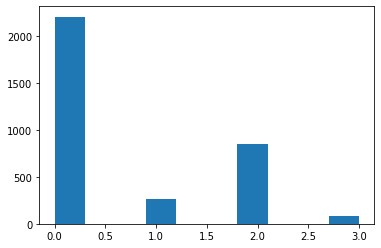

In [22]:
X_test_transf = pd.DataFrame(model2.transform(X_test_sc))
y_pred = clf.predict(X_test_transf)
plt.hist(y_pred)



(array([0.64790384, 0.07856933, 0.24948695, 0.02403987]),
 array([0, 1, 2, 3, 4]),
 <a list of 4 Patch objects>)

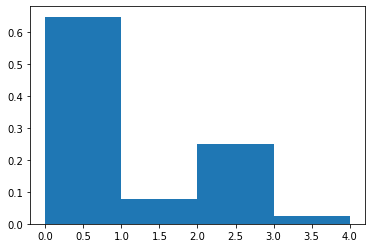

In [26]:
plt.hist(y_pred,bins=[0,1, 2, 3, 4],density=True)

In [27]:
y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
y_pred_pd.to_csv('../../Predictions/XGB_512outliers_295features_test.csv', index_label='id')